In [58]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans, vq
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [59]:
train_dir = './Dataset/Train'
labels = os.listdir(train_dir)
print(labels)

['aeroplane', 'car', 'motorcycle']


In [60]:
image_paths = []
image_labels = []

for i, class_name in enumerate(labels):
    class_dir = train_dir + '/' + class_name
    image_files = os.listdir(class_dir)

    for image_file in image_files:
        image_path = class_dir + '/' + image_file
        image_paths.append(image_path)
        image_labels.append(i)

#print(image_path)
#print(image_labels)

In [61]:
#Feature extraction
SIFT = cv2.SIFT.create()
descriptors=[]

for path in image_paths:
    image= cv2.imread(path)
    _, descriptor = SIFT.detectAndCompute(image, None)
    descriptors.append(descriptor)

In [62]:
#preprocessing
# kita mau format dia sehingga dapat dimasukkan ke function clustering
# kita concat semua descriptor jadi sebuah array

stacked_descriptor = descriptors[0]

for descriptor in descriptors[1:]:
    stacked_descriptor = np.vstack((stacked_descriptor, descriptor))


#perlu float32 krsn varietynya kebanyakan dari opencv itu terima datatype bentuk itu
stacked_descriptor = np.float32(stacked_descriptor)

In [63]:
#clustering -> kmeans (MAININ DISINI)
centroids, _ = kmeans(stacked_descriptor, 20, 20)
image_features = np.zeros((len(image_paths), len(centroids)), "float32")


In [64]:
#vector quantzation -> bikin histogram dari features tadi
for i in range(len(image_paths)):
    #assign descriptor ke centroids yang paling deket
    words, _ = vq(descriptors[i], centroids)
    
    for w in words:
        image_features[i][w] += 1


In [65]:
#feature scalling -> standardize featre vector

scaler = StandardScaler()
scaler.fit(image_features)

image_features = scaler.transform(image_features)


In [66]:
#classification -> 

classifier = SVC()

classifier.fit(image_features, np.array(image_labels))


SVC()

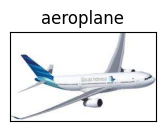

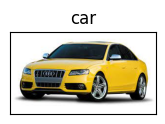

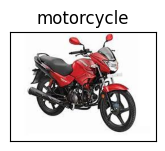

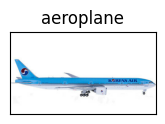

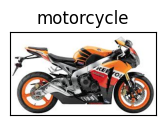

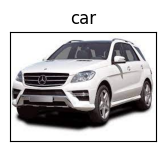

In [67]:
test_dir = './Dataset/Test'
test_image_names = os.listdir(test_dir)

test_image_paths = []

for path in test_image_names:
    test_image_paths.append(test_dir + '/' + path) 

#print(test_image_paths)

#feature extraction
test_descriptors = []

for path in test_image_paths:
    image=cv2.imread(path)
    _, descriptor = SIFT.detectAndCompute(image, None)
    test_descriptors.append(descriptor)
    

test_features = np.zeros((len(test_image_paths), len(centroids)), "float32")

#vector quantzation -> bikin histogram dari features tadi
for i in range(len(test_image_paths)):
    words, _ = vq(test_descriptors[i], centroids)
    
    for w in words:
        test_features[i][w] += 1

#scalling
test_features = scaler.transform(test_features)


#predict w clssifier
result = classifier.predict(test_features)


#plotting
for i, (label, image) in enumerate(zip(result, test_image_names)):
    img = cv2.imread(test_dir + '/' + image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i+1)
    plt.title(labels[label])
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
